In [2]:
import os
os.chdir("/content/drive/MyDrive/Colab/Deep_Dream_Keras_Implementation")

In [58]:
import numpy as np
import scipy
from IPython.display import Image

from keras.preprocessing.image import load_img , img_to_array , save_img
from keras.applications.inception_v3 import InceptionV3 , preprocess_input
from keras.utils import plot_model
from tensorflow.keras import backend as K

In [59]:
layer_contributions = {
    "mixed2" : 0.2 ,
    "mixed3" : 3. ,
    "mixed4" : 2. ,
    "mixed5" : 1.5
}

In [60]:
def preprocess_image(image_path):
  #util function to open , resize and format pictures
  #into appropriate tensors

  img = load_img(image_path)
  img = img_to_array(img)
  img = np.expand_dims(img , axis= 0)
  img = preprocess_input(img)
  return img

In [83]:
def deprocess_image(x):
  #util function to convert a tensor info a valid image
  x = np.copy(x)
  x = x.reshape(( x.shape[1] ,x.shape[2] , 3 ))
  x/=2
  x += 0.5
  x *= 255
  x = np.clip(x , 0 , 255).astype('uint8')

  return x

In [62]:
def resize_img(img , size):
  img = np.copy(img)
  factors = (1 ,
             float(size[0]) / img.shape[1] ,
             float(size[1]) / img.shape[2] ,
             1)

  return scipy.ndimage.zoom(img , factors , order= 1)

In [64]:
model = InceptionV3(weights='imagenet', include_top=False)
layer_dict = {layer.name : layer for layer in model.layers}

Instructions for updating:
Colocations handled automatically by placer.


In [65]:
loss = K.variable(0.)
for layer_name, coeff in layer_contributions.items():
    output = layer_dict[layer_name].output
    scale = K.cast(K.prod(K.shape(output)), 'float32')
    loss = loss + coeff * K.sum(K.square(output[:, 2:-2, 2:-2, :])) / scale


In [66]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

dream = model.input
grads = K.gradients(loss, dream)[0]
grads /= K.maximum(K.mean(K.abs(grads)) , K.epsilon())

fetch_loss_grads = K.function([dream] , [loss , grads])

def eval_loss_grads(x):
  loss_value , grad_value =fetch_loss_grads([x])
  return loss_value , grad_value

def gradient_ascent(img , iterations , lr , max_loss = None):
  for i in range(iterations):
    loss_value , grad_value = eval_loss_grads(img)
    print(f'iter : {i} , loss_value : {loss_value}')
    if max_loss is not None and loss_value > max_loss:
      break
    img += lr * grad_value

  return img

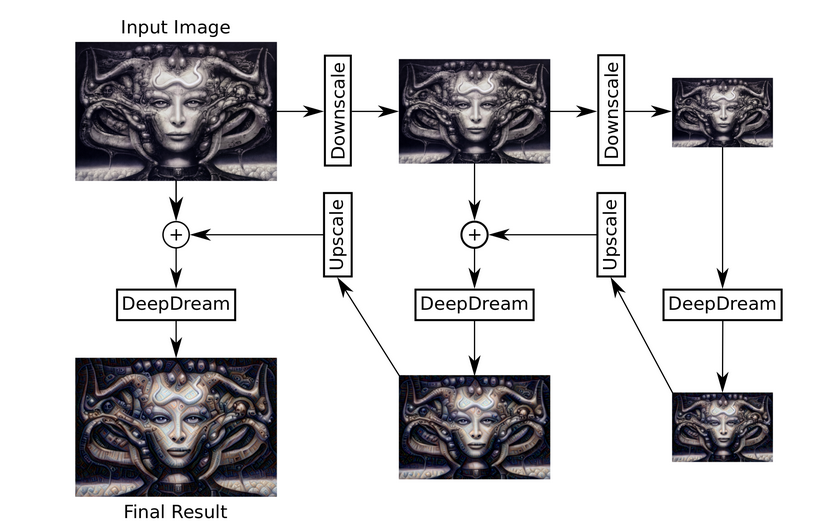

In [63]:
Image('scaling_process.png')

In [67]:
"""Process:
- Load the original image.
- Define a number of processing scales (i.e. image shapes),
    from smallest to largest.
- Resize the original image to the smallest scale.
- For every scale, starting with the smallest (i.e. current one):
    - Run gradient ascent
    - Upscale image to the next scale
    - Reinject the detail that was lost at upscaling time
- Stop when we are back to the original size.
To obtain the detail lost during upscaling, we simply
take the original image, shrink it down, upscale it,
and compare the result to the (resized) original image.
"""

'Process:\n- Load the original image.\n- Define a number of processing scales (i.e. image shapes),\n    from smallest to largest.\n- Resize the original image to the smallest scale.\n- For every scale, starting with the smallest (i.e. current one):\n    - Run gradient ascent\n    - Upscale image to the next scale\n    - Reinject the detail that was lost at upscaling time\n- Stop when we are back to the original size.\nTo obtain the detail lost during upscaling, we simply\ntake the original image, shrink it down, upscale it,\nand compare the result to the (resized) original image.\n'

In [77]:
#playing with these hyperparameters will also allow you to achieve new effects
lr = 0.01 #Gradient ascent step size
num_octave = 3 #number of scales at which to run gradient ascent
octave_scale = 1.4 #size ratio between scales
iterations = 20 #Number of ascent steps per scale
max_loss = 10.
image_path = 'rome.jpg'
result_path = 'rome_dream.jpg'

In [78]:
img = preprocess_image(image_path)
original_shape = img.shape[1 : -1]
original_shape

(801, 1200)

In [79]:
successive_shapes = [original_shape]
for i in range(1 , num_octave):
  shape = tuple([int(dim / (octave_scale**i)) for dim in original_shape])
  successive_shapes.append(shape)

successive_shapes.reverse()
original_img = np.copy(img)
shrunk_original_img = resize_img(img , successive_shapes[0])
print(shrunk_original_img.shape , original_img.shape)

(1, 408, 612, 3) (1, 801, 1200, 3)


In [84]:
for shape in successive_shapes:
  print(f'proccessing shape {shape}')
  img = resize_img(img , shape)
  img = gradient_ascent(img , iterations , lr , max_loss)

  downscale_original_image = resize_img(original_img , shape)
  upscale_shrunk_original_image = resize_img(shrunk_original_img , shape)

  loss_details = downscale_original_image - upscale_shrunk_original_image
  img += loss_details

  shrunk_original_img = resize_img(original_img , shape)

save_img(result_path , deprocess_image(img))

proccessing shape (408, 612)
iter : 0 , loss_value : 6.099667072296143
iter : 1 , loss_value : 8.499251365661621
iter : 2 , loss_value : 9.911988258361816
iter : 3 , loss_value : 10.919719696044922
proccessing shape (572, 857)
iter : 0 , loss_value : 5.586426734924316
iter : 1 , loss_value : 7.906325817108154
iter : 2 , loss_value : 9.369632720947266
iter : 3 , loss_value : 10.459378242492676
proccessing shape (801, 1200)
iter : 0 , loss_value : 4.322454929351807
iter : 1 , loss_value : 6.082757949829102
iter : 2 , loss_value : 7.5992817878723145
iter : 3 , loss_value : 8.976117134094238
iter : 4 , loss_value : 10.348518371582031


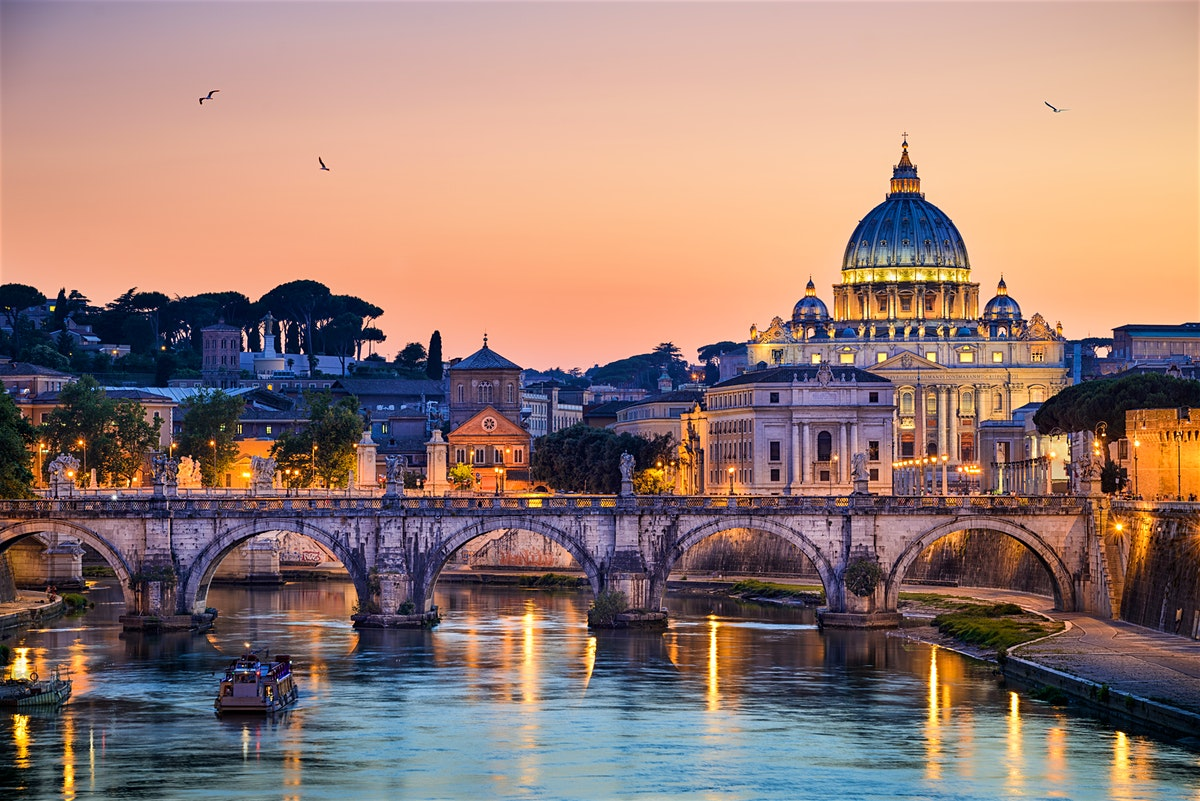

In [81]:
Image(image_path)

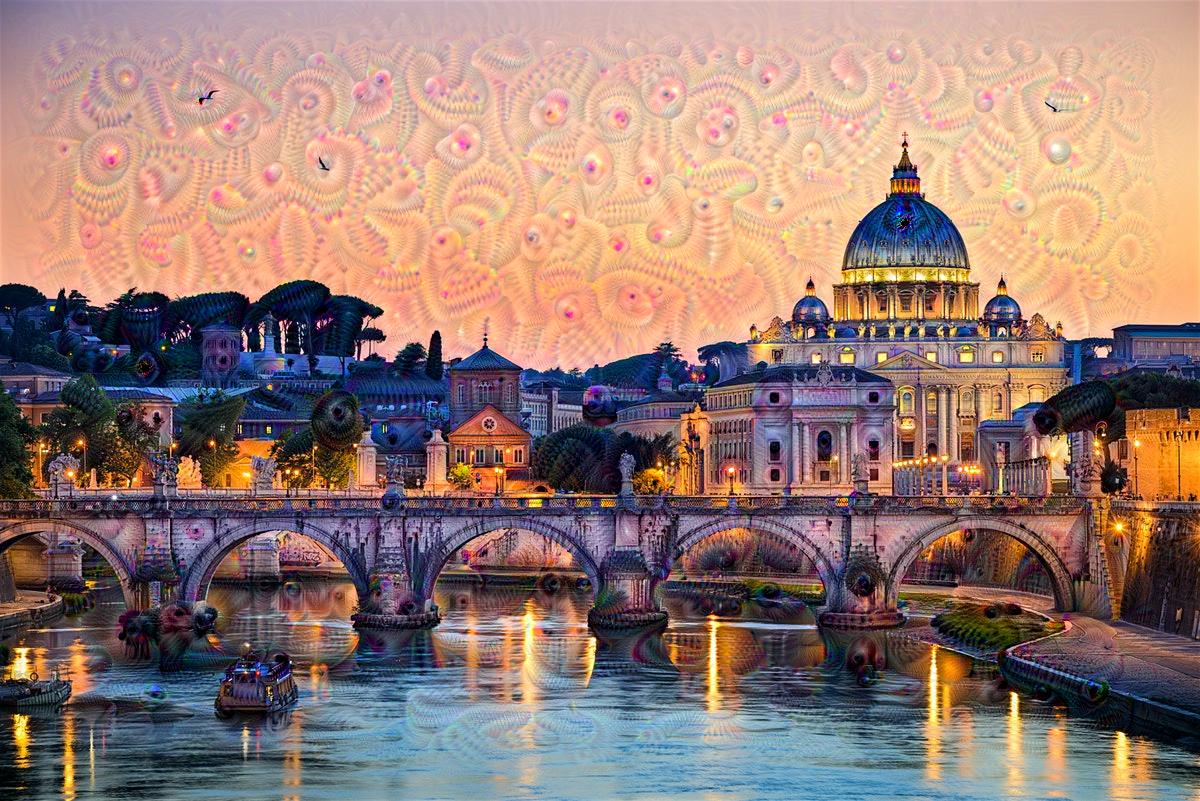

In [85]:
Image(result_path)